# MCM2 phosphoproteomics

This notebook creates a boxplot for the trans effect of PTEN cnv deletions for MCM2 in Gbm.

Imports

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
import plot_utils as p

In [10]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import operator


def wrap_ttest(df, label_column, comparison_columns=None, alpha=.05, return_all=False, correction_method='bonferroni', mincount=3, pval_return_corrected=True):
    try:
        '''Verify precondition that label column exists and has exactly 2 unique values'''
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
       
        '''Partition dataframe into two sets, one for each of the two unique values from the label column'''
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]

        '''If no comparison columns specified, use all columns except the specified labed column'''
        if not comparison_columns:
            comparison_columns = list(df.columns)
            comparison_columns.remove(label_column)

        '''Determine the number of real valued columns on which we will do t-tests'''
        number_of_comparisons = len(comparison_columns)

        '''Store comparisons and p-values in two arrays'''
        comparisons = []
        pvals = []
       
        '''Loop through each comparison column, perform the t-test, and record the p-val'''
       
        for column in comparison_columns:
            if len(partition1[column].dropna(axis=0)) <= mincount:
                continue
            elif len(partition2[column].dropna(axis=0)) <= mincount:
                continue
            else:
                stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
                comparisons.append(column)
                pvals.append(pval)
               
        '''Correct for multiple testing to determine if each comparison meets the new cutoff'''
        results = statsmodels.stats.multitest.multipletests(pvals=pvals, alpha=alpha, method=correction_method)
        reject = results[0]

        '''Format results in a pandas dataframe'''
        results_df = pd.DataFrame(columns=['Comparison','P_Value'])

        '''If return all, add all comparisons and p-values to dataframe'''
        if return_all:
            if pval_return_corrected:
                results_df['Comparison'] = comparisons
                results_df['P_Value'] = results[1]

            else:
                results_df['Comparison'] = comparisons
                results_df['P_Value'] = pvals

            '''Else only add significant comparisons'''
        else:
            for i in range(0, len(reject)):
                if reject[i]:
                    if pval_return_corrected:
                        results_df = results_df.append({'Comparison':comparisons[i],'P_Value':results[1][i]}, ignore_index=True)
                    else:
                        results_df = results_df.append({'Comparison':comparisons[i],'P_Value':pvals[i]}, ignore_index=True)


        '''Sort dataframe by ascending p-value'''
        results_df = results_df.sort_values(by='P_Value', ascending=True)
        results_df = results_df.reset_index(drop=True)

        '''If results df is not empty, return it, else return None'''
        if len(results_df) > 0:
            return results_df
        else:
            return None


    except:
        print("Incorrectly Formatted Dataframe!")
        return None

Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation types from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [209]:
# Returns a dataframe with proteomics and mutation type

def format_df(cancer_object, trans_gene, gene_in = 'PTEN', keep_normal=False, drop_level = 3, utils = u):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'phosphoproteomics', omics_genes = trans_gene)
        if keep_normal == True:
            normal = prot_and_mutations[prot_and_mutations.Sample_Status != "Tumor"] # Keep Normal samples
            normal = normal.iloc[:,:-4]
            if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
                if cancer_object.get_cancer_type() in ('colon'):
                    drop_level -= 1
                normal = utils.reduce_multiindex(
                                            normal, levels_to_drop=[drop_level], flatten=True)
            normal['Muation'] = 'Normal'
            
        
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # Keep Tumor
        
        # Reduce a multiindex 
        
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            if cancer_object.get_cancer_type() in ('colon'):
                drop_level -= 1
            prot_and_mutations = utils.reduce_multiindex(
                                            prot_and_mutations, levels_to_drop=[drop_level], flatten=True)
 

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        
        if keep_normal == True:
            del_wt = del_wt.append(normal)
            
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='phosphoproteomics',genes1= gene_in, 
                genes2=trans_gene, tissue_type = 'tumor')
            
        omics = u.reduce_multiindex(omics, levels_to_drop = [2,3], flatten = True)
        omics = omics.drop(columns='PTEN_CNV')

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type)
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        '''
        if keep_normal == True:
            normal = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='phosphoproteomics',genes1= gene_in, 
                genes2=trans_gene, tissue_type = 'normal')
            print(normal)
            normal = normal.loc[normal['Mutation_Status'] == 'Normal_Wildtype']
            normal = normal.iloc[:,:-4]
            if isinstance(normal.keys(), pd.core.indexes.multi.MultiIndex):
                if cancer_object.get_cancer_type() in ('colon'):
                    drop_level -= 1
                normal = utils.reduce_multiindex(normal, levels_to_drop=[drop_level], flatten=True)
            del_wt = del_wt.append(normal)'''


    return del_wt


In [191]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac. Note: Keep the variable names the same because they are used in format_df to reduce multiindexs found in certain cancer data sets. 

In [192]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
g = cptac.Gbm()
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
col = cptac.Colon()
b = cptac.Brca()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


version 3scc v3.2.......                 


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 5)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

In [193]:
gene = 'PTEN'
t_gene = 'MCM2'

cancer_objects = {'Gbm':g, 'Hnscc':h, 'Luad':l, 'Lscc':ls, 'Brca':b, 'Colon':col, 'Ov':o}

In [197]:
sig_results = []
dfs = {}
for cancer in cancer_objects:
    del_wt = format_df(cancer_objects[cancer], t_gene)
    print(cancer)
    print(len(del_wt),'\n')
    #print(del_wt.columns, '\n')
    dfs[cancer] = del_wt
    
    # T-test
    cols_in = list(del_wt.columns[:-1])

    # Get all pvals
    min_num = 6
    all_pval = wrap_ttest(del_wt, 'Mutation', cols_in, return_all = True, 
                          correction_method = 'fdr_bh', mincount = min_num)
    sig_df = all_pval.loc[all_pval['P_Value'] < 0.05]
    sig_results.append(sig_df)

print('done') # check ov

Gbm
97 

Hnscc
105 

Luad
105 

Lscc
99 

Brca
104 

Colon
101 

Ov
66 

done


In [211]:
normal_dfs = {}
for cancer in cancer_objects:
    del_wt = format_df(cancer_objects[cancer], t_gene, keep_normal=True)
    print(cancer)
    print(len(del_wt),'\n')
    normal_dfs[cancer] = del_wt

Gbm
107 

Hnscc
174 

Luad
105 

Lscc
198 

Brca
104 



ValueError: Plan shapes are not aligned

In [56]:
for sig_df in sig_results:
    print(sig_df, '\n')

                                       Comparison   P_Value
0  MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK  0.001535
1  MCM2_phosphoproteomics_S139_RGLLYDS*DEEDEERPAR  0.005796
2   MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR  0.015731
3         MCM2_phosphoproteomics_S27_GNDPLTSS*PGR  0.015731 

Empty DataFrame
Columns: [Comparison, P_Value]
Index: [] 

Empty DataFrame
Columns: [Comparison, P_Value]
Index: [] 

Empty DataFrame
Columns: [Comparison, P_Value]
Index: [] 

Empty DataFrame
Columns: [Comparison, P_Value]
Index: [] 

Empty DataFrame
Columns: [Comparison, P_Value]
Index: [] 

Empty DataFrame
Columns: [Comparison, P_Value]
Index: [] 



In [212]:
# Get sites with S41
s41_dfs = {}
all_s41 = pd.DataFrame()
for cancer in dfs:
    df = dfs[cancer]
    cols = df.columns
    bool_cols = df.columns.str.contains('S41', regex=True)
    sites = list(cols[bool_cols])
    sites.append('Mutation')
    #print(sites)
    s41_df = df[sites]
    # format for boxplot
    s41_df = s41_df.melt(id_vars='Mutation')
    s41_df['Name'] = cancer+'_' + s41_df['Name'].astype(str)
    s41_df = s41_df.assign(cancer = cancer)
    all_s41 = all_s41.append(s41_df)
    #s41_dfs[cancer] = s41_df

In [213]:
all_s41 = all_s41.loc[all_s41['cancer'] != 'Hnscc']
test = all_s41.loc[all_s41['Mutation'] == 'Wildtype']
test.cancer.value_counts()

Series([], Name: cancer, dtype: int64)

In [214]:
all_s41 = all_s41.replace(to_replace = r'_phosphoproteomics', value = '', regex = True)
all_s41 = all_s41.replace(to_replace = r'_([A-Za-z*.]*)$', value = '', regex = True)
all_s41.Name.unique()


array(['Gbm_MCM2_S40S41', 'Gbm_MCM2_S41', 'Luad_MCM2_S40S41',
       'Lscc_MCM2_S40S41', 'Lscc_MCM2_S41M77', 'Brca_MCM2_S40S41',
       'Brca_MCM2_S41', 'Colon_MCM2_S41', 'Ov_MCM2_S41'], dtype=object)

# Create the Boxplot of S41

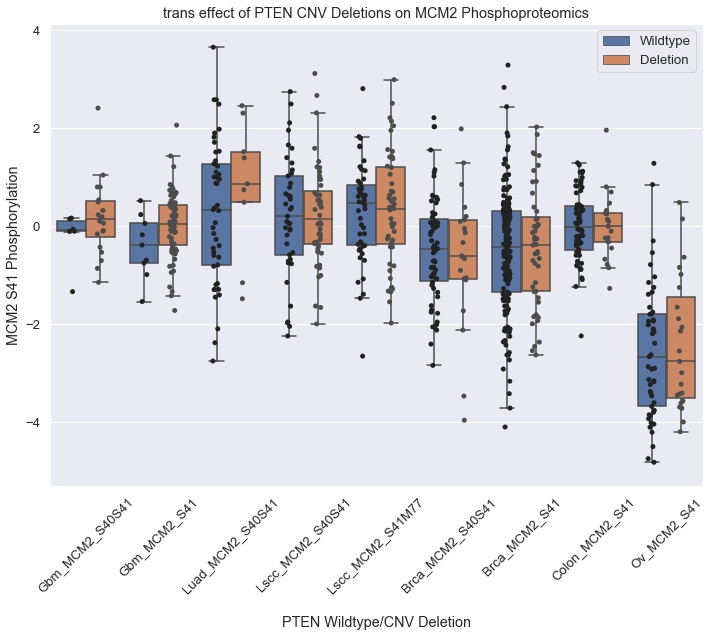

In [215]:
gene = 'PTEN'
t_gene='MCM2'
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='Name', y='value', data = all_s41, hue ='Mutation',
                      hue_order = ["Wildtype", "Deletion"],
                      showfliers = False)    
boxplot.set_title('trans effect of PTEN CNV Deletions on '+t_gene+' Phosphoproteomics')
boxplot = sns.stripplot(x='Name', y='value', data = all_s41, jitter = True, 
                           color = ".3",dodge = True, hue = 'Mutation',
                        hue_order = ["Wildtype", "Deletion"])
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion", ylabel = t_gene+' S41 Phosphorylation')

boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])



# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 

#format_pval_annotation("**", -.2, .2, 4.3) 



plt.show()
plt.clf()
plt.close()

In [143]:
ls_pval

,Comparison,P_Value
0,MCM2_phosphoproteomics_T25_RRGNDPLtSSPGR,0.000268
1,MCM2_phosphoproteomics_S41M77_RTDALTSsPGRDLPPF...,0.000956
2,MCM2_phosphoproteomics_S139_GLLYDsDEEDEERPAR,0.001413


In [144]:
g_pval

,Comparison,P_Value
0,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK,0.000192
1,MCM2_phosphoproteomics_S139_RGLLYDS*DEEDEERPAR,0.001449


In [ ]:
# Save figure
#fig = boxplot.get_figure()
#fig.savefig(".png")